In [19]:
import numpy as np
import os

data_path = '/home/yigit/Documents/projects/irl_sfm/data/demonstrations/sfm/small_env_changing_s_g/used_solid/'
out_path = '/home/yigit/phd/yigit_phd_thesis/cnmp/data/sfm/small_env_changing_s_g/generate_trajectory/'

try:
    os.mkdir(f'{out_path}demonstrations')
    os.mkdir(f'{out_path}novel')
except:
  pass

demonstrations = {}
novel_demonstrations = []

for filename in os.listdir(data_path):
    if filename.endswith(".npy"):
        config_str = filename.strip('.npy')
        path = os.path.join(data_path, filename)
        demonstrations[config_str] = np.load(path, allow_pickle=True, encoding='latin1')
#         print(f'{len(demonstrations)-1}: {path}')

novel_data_path = '/home/yigit/Documents/projects/irl_sfm/data/demonstrations/sfm/small_env_changing_s_g/novel/'#os.path.join(data_path, 'novel/')
for filename in os.listdir(novel_data_path):
    if filename.endswith(".npy"):
        path = os.path.join(novel_data_path, filename)
        novel_demonstrations.append(np.load(path, allow_pickle=True, encoding='latin1'))

num_demos = len(demonstrations)
num_novel = len(novel_demonstrations)

In [20]:
print(num_demos)
print(num_novel)
print(demonstrations[list(demonstrations.keys())[0]].shape)  #time_step x data_dim

7908
9
(533, 8)


In [21]:
def config_to_list_(cfg):  # cfg: sx_<>_sy_<>_..., cfg_list: [<sx>,<sy>,<gx>,<gy>,<x>,<y>]
    cfg_str_list = cfg.split('_')
    cfg_list = []
    index = 0
    cfg_list = [float(cfg_str_list[1]), float(cfg_str_list[3]), float(cfg_str_list[5]),
                float(cfg_str_list[7]), float(cfg_str_list[9]), float(cfg_str_list[11])]
    return cfg_list

In [22]:
def config_to_list(cfg):
    cfg_str_list = cfg.split('_')
    cfg_list = []
    index = 0
    for i in range(6):
        if i==1:
            cfg_list.append(0.0)
            index+=1
        elif i==3:
            cfg_list.append(13.0)
            index+=1
        else:
            cfg_list.append(float(cfg_str_list[i - index]))
    return cfg_list

In [23]:
from tqdm import tqdm

desired_len = 400 # min_len
y_dim, t_dim, gamma_dim = 2, 1, 6

ldy, ldt, ldgamma = [], [], []

n_y = np.zeros((num_novel, desired_len, y_dim))
n_t =  np.zeros((num_novel, desired_len, t_dim))
n_gamma = np.zeros((num_novel, desired_len, gamma_dim))

for i, config in enumerate(tqdm(demonstrations)):
    demo = demonstrations[config]
    config_list = config_to_list_(config)
    len_demo = len(demo)
#     print(len_demo)
    indices = np.linspace(10, len_demo-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    y, t, gamma = np.zeros((desired_len, y_dim)), np.zeros((desired_len, t_dim)), np.zeros((desired_len, gamma_dim))
    for new_ind, old_ind in enumerate(indices):
        y[new_ind] = demo[old_ind][-y_dim:]  # -2, -1 dims are pose_x and pose_y
        t[new_ind] = new_ind
        gamma[new_ind] = config_list
    
    ldy.append(y)
    ldt.append(t)
    ldgamma.append(gamma)

print("Copying: ", end='')
num_demos = len(ldy)

d_y = np.zeros((num_demos, desired_len, y_dim))
d_t =  np.zeros((num_demos, desired_len, t_dim))
d_gamma = np.zeros((num_demos, desired_len, gamma_dim))

for i in tqdm(range(num_demos)):
    d_y[i] = ldy[i]
    d_t[i] = ldt[i]
    d_gamma[i] = ldgamma[i]

#############
# novel case
#############

# for i, demo in enumerate(novel_demonstrations):
#     len_demo = len(demo)
#     indices = np.linspace(0, len_demo-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
#     x, t, m = np.zeros((desired_len, x_dim)), np.zeros((desired_len, t_dim)), np.zeros((desired_len, m_dim))
#     for new_ind, old_ind in enumerate(indices):
#         x[new_ind] = demo[old_ind][:x_dim]
#         t[new_ind] = new_ind
#         m[new_ind] = config_list
#     n_X[i] = x
#     n_Gamma[i] = gmm
#     n_Y[i] = y

100%|██████████| 7908/7908 [00:00<00:00, 57449.75it/s]

Copying: 

[Text(0, 0.5, 'pose_y'), Text(0.5, 0, 'pose_x')]

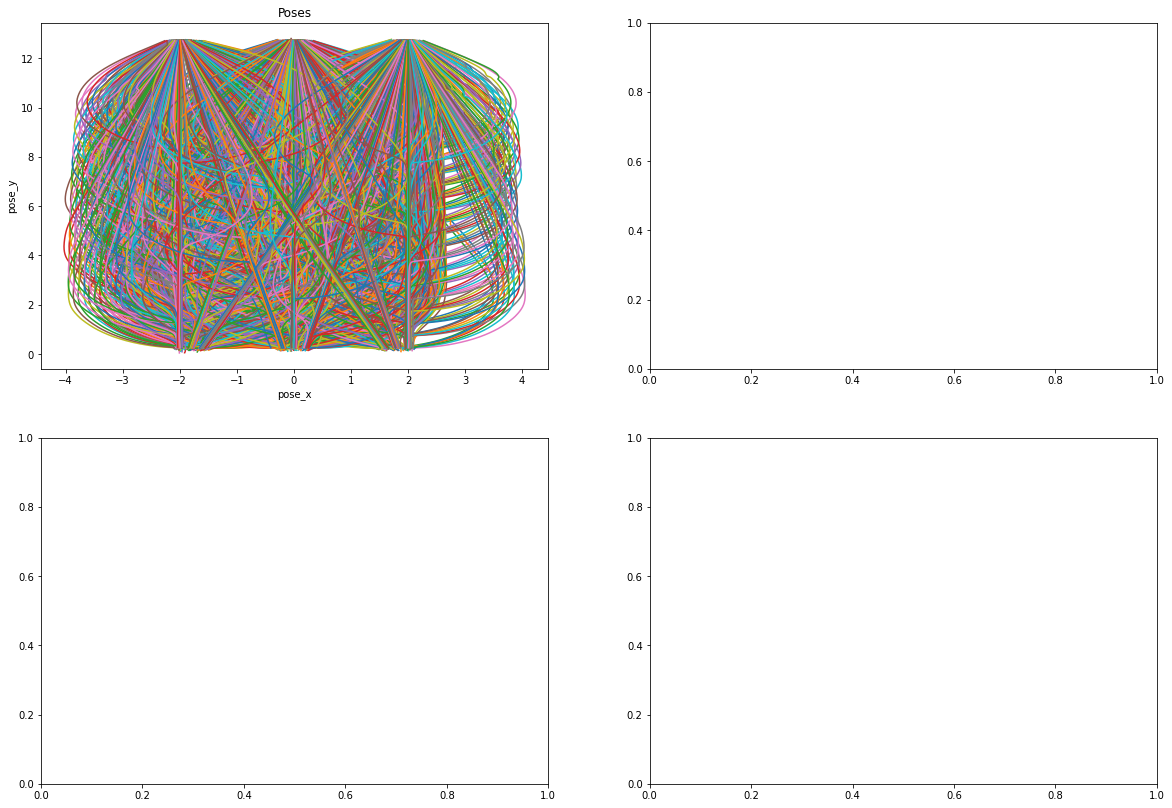

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 14]

fig, axs = plt.subplots(2, 2)
for i in range(num_demos):
    axs[0, 0].plot(d_y[i][:, 0], d_y[i][:, 1])  # x, y poses
axs[0, 0].set_title('Poses')
axs[0, 0].set(xlabel='pose_x', ylabel='pose_y')

# for i in range(num_demos):
#     axs[0, 1].plot(range(len(d_Y[i])), d_Y[i][:, 1])  # v_y
# axs[0, 1].set_title('v_y values')
# axs[0, 1].set(xlabel='step', ylabel='speed')

# for i in range(num_novel):
#     axs[1, 0].plot(range(len(n_Y[i])), n_Y[i][:, 0])  # v_x
# axs[1, 0].set_title('novel v_x values')
# axs[1, 0].set(xlabel='step', ylabel='speed')

# for i in range(num_novel):
#     axs[1, 1].plot(range(len(n_Y[i])), n_Y[i][:, 1])  # v_y
# axs[1, 1].set_title('novel v_y values')
# axs[1, 1].set(xlabel='step', ylabel='speed')

In [27]:
print(len(d_t))

7908


In [28]:
num_val = 500  # 1000 out of ~28000 

y_train, y_val, t_train, t_val, gamma_train, gamma_val = [], [], [], [], [], []
val_indices = np.sort(np.random.choice(range(num_demos-1), num_val, replace=False))

for i in range(num_demos):
    if i in val_indices:  # validation instance
#         print(f'val: {i}')
        y_val.append(d_y[i])
        gamma_val.append(d_gamma[i])
        t_val.append(d_t[i])
    else:  # training instance
        y_train.append(d_y[i])
        gamma_train.append(d_gamma[i])
        t_train.append(d_t[i])
        
np.save(out_path + 'demonstrations/' + 'd_y.npy', np.array(y_train))
np.save(out_path + 'demonstrations/' + 'd_t.npy', np.array(t_train))
np.save(out_path + 'demonstrations/' + 'd_gamma.npy', np.array(gamma_train))
np.save(out_path + 'demonstrations/' + 'v_d_y.npy', np.array(y_val))
np.save(out_path + 'demonstrations/' + 'v_d_t.npy', np.array(t_val))
np.save(out_path + 'demonstrations/' + 'v_d_gamma.npy', np.array(gamma_val))

#############
# novel case
#############

np.save(out_path + 'novel/' + 'd_x.npy', np.array(n_X))
np.save(out_path + 'novel/' + 'd_y.npy', np.array(n_Y))
np.save(out_path + 'novel/' + 'd_gamma.npy', np.array(n_Gamma))

NameError: name 'n_X' is not defined